In [1]:
from pathlib import Path
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import betabinom
from scipy.stats import dirichlet
from scipy import stats
from plot_params import *
basedir = Path('/home/hsher/scratch/ABC_2rep')
out_stem = 'K562_rep6'

In [2]:
raw_data = pd.read_csv(basedir /f'counts/genome/megatables/{out_stem}.tsv.gz', sep = '\t')
raw_data = raw_data.loc[raw_data.sum(axis = 1)>10]
raw_data.index = raw_data.index+1

weights = pd.read_csv(basedir/f'DMM/{out_stem}.weights.tsv', sep = '\t', index_col = 0)
weights.index = [f'V{i}' for i in weights.index]


model_alphas = pd.read_csv(basedir/f'DMM/{out_stem}.alpha.tsv', sep = '\t',
                          index_col = 0) # RBP by components, B * K
model_alphas.columns = [c.replace('X', 'V') for c in model_alphas.columns]
model_mean = model_alphas.div(model_alphas.sum(axis = 0), axis = 1)
model_var = model_alphas.apply(lambda column: dirichlet(column).var(), axis = 0)
null_alphas = pd.read_csv(basedir /f'DMM/{out_stem}.null.alpha.tsv', sep = '\t', index_col = 0)['single_component_weight']

anno = pd.read_csv(basedir/f'DMM/{out_stem}.cluster_annotation_binary.csv',
                          index_col = 0) # RBP by components, B * K

In [3]:
ground_truth_eclip = pd.read_csv('ABC_K562.skipper_reproducible_window.csv',
                          index_col = 0)
ground_truth_eclip.rename({'DDX3X':'DDX3'}, axis = 1, inplace = True)
clipper_windows = pd.read_csv('Dan_multiplex1_K562_rep4.window.csv', index_col = 0)
clipper_pv = pd.read_csv('Dan_multiplex1_K562_rep4.best_pval_perwindow.csv', index_col = 0)
clipper_fc = pd.read_csv('Dan_multiplex1_K562_rep4.best_fc_perwindow.csv', index_col = 0)

In [4]:
from scipy.stats import betabinom
class Beta_Mixture_Model:
    def __init__(self, alphas, betas, weights, n):
        self.alphas = alphas # (alpha, beta) of each component, K*2 matrix
        self.betas = betas
        self.weights = weights # vector of length K
        self.n = n
        
        self.distributions = []
        
        for a,b in zip(self.alphas, self.betas):
            self.distributions.append(betabinom(a = a, b = b, n = n))
        
    def pmf(self,k):
        ''' return pmf of  mixture model'''
        p = 0
        for w, dist in zip(self.weights, self.distributions):
            p += w*dist.pmf(k)
        return p
    
    def cdf(self,k):
        p = 0
        for w, dist in zip(self.weights, self.distributions):
            p += w*dist.cdf(k)
        return p
    def logpmf(self,k):
        return np.log(self.pmf(k))
    def pvalue(self,k):
        return 1-self.cdf(f)
import tensorflow_probability as tfp
class Dirichlet_Mixture_Model:
    def __init__(self, alphas, weights, n):
        
        self.alphas = alphas # (alpha, beta) of each component, K*2 matrix
        self.weights = weights # vector of length K
        self.n = n
        
        self.distributions = []
        
        for a in self.alphas:
            self.distributions.append(tfp.distributions.DirichletMultinomial(n, a))
    def pmf(self,k):
        ''' return pmf of  mixture model'''
        p = 0
        for w, dist in zip(self.weights, self.distributions):
            p += w*dist.prob(k)
        return p
    
    def cdf(self,k):
        raise NotImplementedError
    def logpmf(self,k):
        return np.log(self.pmf(k))
    def pvalue(self,k):
        raise NotImplementedError

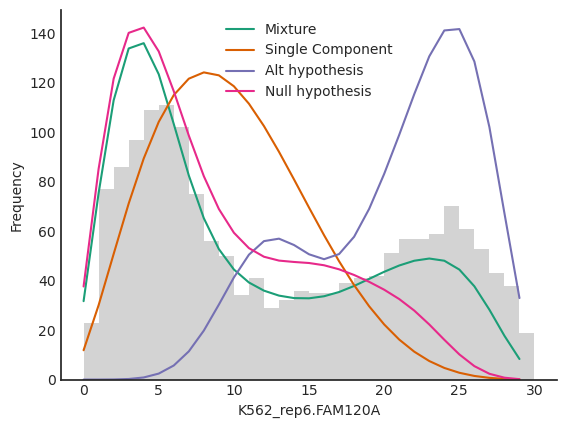

In [5]:
rbps = [f'{out_stem}.FAM120A']
nread = 30
subset = raw_data.loc[raw_data.sum(axis = 1) == nread]
b = Beta_Mixture_Model(
                       model_alphas.loc[model_alphas.index.isin(rbps)].sum(axis = 0), 
                       model_alphas.loc[~model_alphas.index.isin(rbps)].sum(axis = 0),
                       weights['pi'],
                        nread)
b_single = betabinom(a=null_alphas.loc[model_alphas.index.isin(rbps)].sum(axis = 0),
                      b=null_alphas.loc[~model_alphas.index.isin(rbps)].sum(axis = 0),
                      n = nread)

# identify components supporting the theory
components = (anno.sum(axis = 1).eq(len(rbps)))&(anno.T.loc[rbps].all(axis = 0))
comp_names = anno.loc[components].index
other_names = anno.loc[~components].index
if 'alpha' in model_alphas.columns[0]:
    comp_names = [f'alpha.{c}' for c in comp_names]
    other_names = [f'alpha.{c}' for c in other_names]

alt_w = weights.loc[components, 'pi']
alt_w = alt_w/alt_w.sum()
alt = Beta_Mixture_Model(model_alphas.loc[model_alphas.index.isin(rbps), comp_names].sum(axis = 0),
                         model_alphas.loc[~model_alphas.index.isin(rbps), comp_names].sum(axis = 0),
                         alt_w,
                        n = nread)

null_w = weights.loc[~components, 'pi']
null_w = null_w/null_w.sum()
null = Beta_Mixture_Model(model_alphas.loc[model_alphas.index.isin(rbps), other_names].sum(axis = 0),
                         model_alphas.loc[~model_alphas.index.isin(rbps), other_names].sum(axis = 0),
                         null_w,
                         n = nread)

x = np.arange(nread)
mix_pmf = b.pmf(x)
alt_pmf = alt.pmf(x)
null_pmf = null.pmf(x)
pmf = b_single.pmf(x)
f, ax = plt.subplots()

subset[rbps].sum(axis = 1).plot.hist(ax = ax, bins = nread, color = 'lightgrey')
ax.plot(x, mix_pmf*subset.shape[0], label = 'Mixture')
ax.plot(x, pmf*subset.shape[0], label = 'Single Component')
ax.plot(x, alt_pmf*subset.shape[0], label = 'Alt hypothesis')
ax.plot(x, null_pmf*subset.shape[0], label = 'Null hypothesis')

ax.set_xlabel('+'.join(rbps))
ax.legend()
sns.despine()




plt.savefig(figdir/'DMM_marginalized_fit.pdf')

2023-04-28 11:43:32.379432: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-28 11:43:32.818196: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


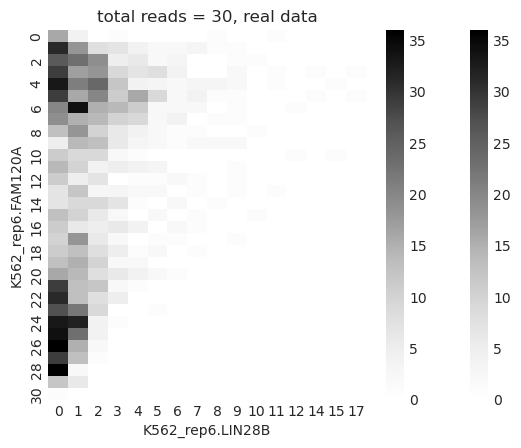

In [6]:
rbps = [f'{out_stem}.FAM120A', f'{out_stem}.LIN28B']
nread = 30
subset = raw_data.loc[raw_data.sum(axis = 1) == nread]

# marginalize the rest into other

marginalized_alphas = pd.concat([model_alphas.loc[rbps].T, 
                                 model_alphas.loc[~model_alphas.index.isin(rbps)].sum(axis = 0)],
                               axis = 1)

b = Dirichlet_Mixture_Model(
                       marginalized_alphas.values,
                       weights['pi'],
                        nread)


c = subset.groupby(by = rbps).count().iloc[:,0].to_frame()
c.columns = ['count']
c = pd.pivot_table(c,
               index = rbps[0],
               columns = rbps[1],
               values = 'count').fillna(0)
sns.heatmap(c, cmap = 'Greys')
plt.title('total reads = 30, real data')


c = subset.groupby(by = rbps).count().iloc[:,0].to_frame()
c.columns = ['count']
c = pd.pivot_table(c,
               index = rbps[0],
               columns = rbps[1],
               values = 'count').fillna(0)
sns.heatmap(c, cmap = 'Greys')
plt.title('total reads = 30, real data')
plt.savefig(figdir/'DMM_raw_data.pdf')

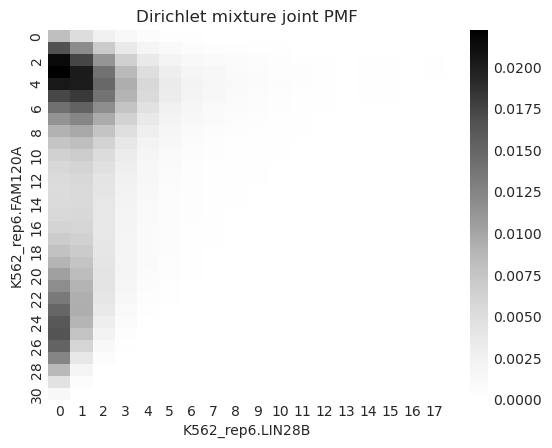

In [7]:
ma = np.zeros((c.index.max()+1, c.columns.max()+1))
for i in c.index:
    for j in c.columns:
        if i+j<= nread:
            ma[i,j]=b.pmf([i,j,nread-i-j])
            
sns.heatmap(ma, cmap = 'Greys')
plt.title('Dirichlet mixture joint PMF')
plt.xlabel(f'{out_stem}.LIN28B')
plt.ylabel(f'{out_stem}.FAM120A')
plt.savefig(figdir/'DMM_fit.pdf')

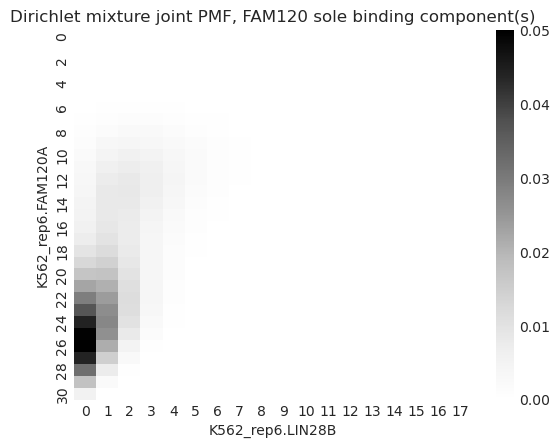

In [8]:
rbps = [f'{out_stem}.FAM120A']
components = (anno.sum(axis = 1).eq(len(rbps)))&(anno.T.loc[rbps].all(axis = 0))
comp_names = anno.loc[components].index
other_names = anno.loc[~components].index
if 'alpha' in model_alphas.columns[0]:
    comp_names = [f'alpha.{c}' for c in comp_names]
    other_names = [f'alpha.{c}' for c in other_names]

alt_w = weights.loc[components, 'pi']
alt_w = alt_w/alt_w.sum()
alt = Dirichlet_Mixture_Model(marginalized_alphas.loc[comp_names].values,
                         alt_w,
                        n = nread)

null_w = weights.loc[~components, 'pi']
null_w = null_w/null_w.sum()
null = Dirichlet_Mixture_Model(marginalized_alphas.loc[other_names].values,
                         null_w,
                         n = nread)
ma = np.zeros((c.index.max()+1, c.columns.max()+1))
for i in c.index:
    for j in c.columns:
        if i+j<= nread:
            ma[i,j]=alt.pmf([i,j,nread-i-j])
sns.heatmap(ma, cmap = 'Greys')
plt.title('Dirichlet mixture joint PMF, FAM120 sole binding component(s)')
plt.xlabel(f'{out_stem}.LIN28B')
plt.ylabel(f'{out_stem}.FAM120A')
plt.savefig(figdir/'DMM_fit_FAM120Aonly.pdf')

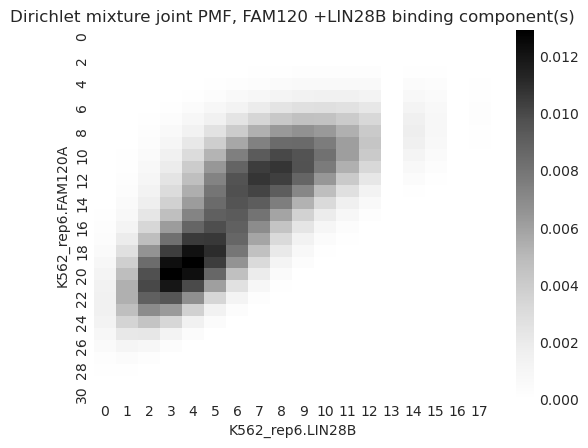

In [9]:
rbps = [f'{out_stem}.FAM120A', f'{out_stem}.LIN28B']
components = (anno.sum(axis = 1).eq(len(rbps)))&(anno.T.loc[rbps].all(axis = 0))
comp_names = anno.loc[components].index
other_names = anno.loc[~components].index
if 'alpha' in model_alphas.columns[0]:
    comp_names = [f'alpha.{c}' for c in comp_names]
    other_names = [f'alpha.{c}' for c in other_names]

alt_w = weights.loc[components, 'pi']
alt_w = alt_w/alt_w.sum()
alt = Dirichlet_Mixture_Model(marginalized_alphas.loc[comp_names].values,
                         alt_w,
                        n = nread)

null_w = weights.loc[~components, 'pi']
null_w = null_w/null_w.sum()
null = Dirichlet_Mixture_Model(marginalized_alphas.loc[other_names].values,
                         null_w,
                         n = nread)
ma = np.zeros((c.index.max()+1, c.columns.max()+1))
for i in c.index:
    for j in c.columns:
        if i+j<= nread:
            ma[i,j]=alt.pmf([i,j,nread-i-j])
sns.heatmap(ma, cmap = 'Greys')
plt.title('Dirichlet mixture joint PMF, FAM120 +LIN28B binding component(s)')
plt.xlabel(f'{out_stem}.LIN28B')
plt.ylabel(f'{out_stem}.FAM120A')
plt.savefig(figdir/'DMM_fit_shared.pdf')

In [10]:
rbp = 'FAM120A'
exp = out_stem.split('_')[0]
raw_binary_counts = pd.read_csv(basedir / 'counts_CC/genome/bgtables/internal/' / 
                                f'{exp}.{rbp}.tsv.gz',
                               sep = '\t')

In [11]:
raw_binary_counts.head()

,chr,start,end,name,score,strand,K562_rep4.FAM120A,K562_rep6.FAM120A,K562_rep4.internal,K562_rep6.internal
0,chr1,629639,629733,1,0,+,43,56,207,242
1,chr1,629733,629828,2,0,+,57,61,251,278
2,chr1,629828,629923,3,0,+,42,35,187,190
3,chr1,629923,630018,4,0,+,35,43,141,166
4,chr1,630018,630113,5,0,+,9,9,36,55


/scratch/hsher/31461425.tscc-mgr7.local/ipykernel_12213/915865116.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cov_df['bound']=cov_df['name'].isin(bound)


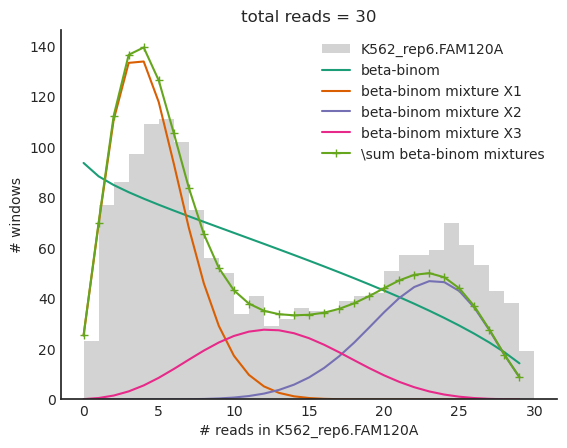

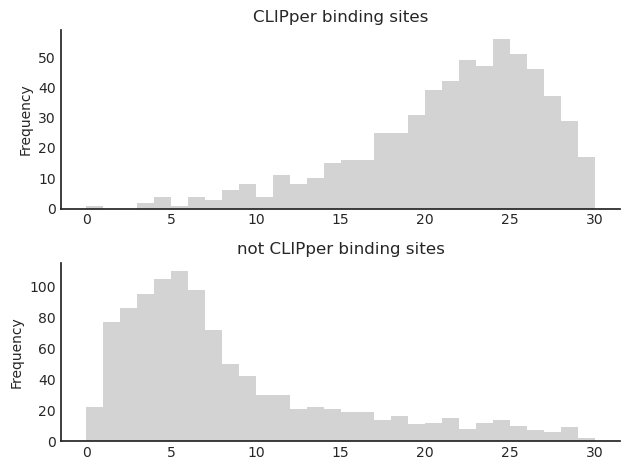

In [12]:
ip = f'{out_stem}.{rbp}'
cc = f'{out_stem}.internal'
col = [ip, cc]
cov = 30
cov_df = raw_binary_counts.loc[raw_binary_counts[col].sum(axis = 1)==cov]
cov_df[ip].plot.hist(bins = cov_df[ip].max(), color = 'lightgrey')
max_read = cov_df[ip].max()

null_alpha = pd.read_csv(basedir / 'beta-mixture_CC' / f'{ip}.null.alpha.tsv',
                               sep = '\t', index_col = 0)
plt.plot([betabinom(a = null_alpha.loc[ip, 'single_component_weight']
                    , b = null_alpha.loc[cc, 'single_component_weight'], n = cov).pmf(
    k = k)*cov_df.shape[0] for k in range(max_read)], label = 'beta-binom')

alpha = pd.read_csv(basedir / 'beta-mixture_CC' / f'{ip}.alpha.tsv',
                               sep = '\t', index_col = 0)
w = pd.read_csv(basedir / 'beta-mixture_CC' / f'{ip}.weights.tsv',
                               sep = '\t', index_col = 0)
w.index = [f'X{i}' for i in w.index]

y_sum = []
for comp in alpha.columns:
    y = [betabinom(a = alpha.loc[ip, comp]
                    , b = alpha.loc[cc, comp], n = cov).pmf(
    k = k)*cov_df.shape[0]*w.loc[comp, 'pi'] for k in range(max_read)]
    plt.plot(y, label = f'beta-binom mixture {comp}')

    y_sum.append(np.array(y))

y_sum = np.stack(y_sum).sum(axis =0)
plt.plot(y_sum, label = f'\sum beta-binom mixtures', marker='+')

plt.xlabel(f'# reads in {ip}')
plt.ylabel('# windows')
plt.title(f'total reads = {cov}')
sns.despine()
plt.legend()
#plt.ylim(0,50)

bound = ground_truth_eclip.loc[ground_truth_eclip[ip.split('.')[1]]].index
cov_df['bound']=cov_df['name'].isin(bound)
f, ax = plt.subplots(2,1)
cov_df.loc[(cov_df['bound']), ip].plot.hist(
    bins = max_read, range = (0,max_read), ax = ax[0], color = 'lightgrey',
    title = 'CLIPper binding sites')

cov_df.loc[(~cov_df['bound']), ip].plot.hist(
    bins = max_read, range = (0,max_read), ax = ax[1], color = 'lightgrey',
    title = 'not CLIPper binding sites')
sns.despine()
plt.tight_layout()

# for comp in alpha.columns:
#     ax[1].plot([betabinom(a = alpha.loc[ip, comp]
#                     , b = alpha.loc[cc, comp], n = cov_df['bound'].sum()).pmf(
#     k = k)*cov_df.shape[0] for k in range(15)], label = f'beta-binom mixture {comp}')
    
    
#     ax[0].plot([betabinom(a = alpha.loc[ip, comp]
#                     , b = alpha.loc[cc, comp], n = (1-cov_df['bound']).sum()).pmf(
#     k = k)*cov_df.shape[0] for k in range(15)], label = f'beta-binom mixture {comp}')

#     plt.legend()
plt.savefig(figdir/'Beta_fit.pdf')